# Коллаборативная фильтрация

Нужно самостоятельно реализовать колоборативную фильтрацию методами:

1. Knn нужно реализовать 2 базовых метода
    1. Простой KNN (в библиотеке surprise называется KNNBasic)
    2. Непараметрическая регрессия Надарайя-Ватсона (в библиотеке surprise называется KNNWithMeans)
2. SVD-разложение
    1. Метод SGD
    2. Метод ALS
3. SVD++

С полученными методами нужно произвести следующие исследования:
- Нужно сравнить время работы всех реализованных алгоритмов. 
- Нужно сравнить точность (в смысле RMSE) всех реализованных алгоритмов.
- Качество (в смысле RMSE) kNN по параметру k
- Качество (в смысле RMSE) SVD по числу факторов
- Качество (в смысле RMSE) SVD по числу итераций в SGD

В качестве датасэта можно использовать, например, https://grouplens.org/datasets/movielens/ (можно любой другой).

Можно вдохновляться библиотеками (но не копировать код): 
- https://implicit.readthedocs.io/en/latest/quickstart.html 
- https://surprise.readthedocs.io/en/stable/getting_started.html

## Data Preprocessing

In [6]:
from surprise import Dataset

# movielens dataset https://grouplens.org/datasets/movielens/
dataset = Dataset.load_builtin('ml-100k')

# all existing ratings (that's why `full`)
trainset = dataset.build_full_trainset()

# all absent ratings
# note: not NAs but with set complement (that's why `anti`)
_testset = trainset.build_anti_testset()

Таблица супер разрежена:

In [ ]:
total = len(trainset.ur) * len(trainset.ir)
unknown = len(_testset)
print(f'total ratings: {total}\nunknown ratings: {unknown} ({unknown/total*100:.2f}%)')

total ratings: 1586126
unknown ratings: 1486126 (93.70%)


Поэтому уменьшим размер тестовой выборки до размеров трейновой выборки

In [ ]:
from random import sample

test_size = total - unknown
testset = sample(_testset, test_size)
print(len(testset))

100000


In [ ]:
trainset.rating_scale

(1, 5)

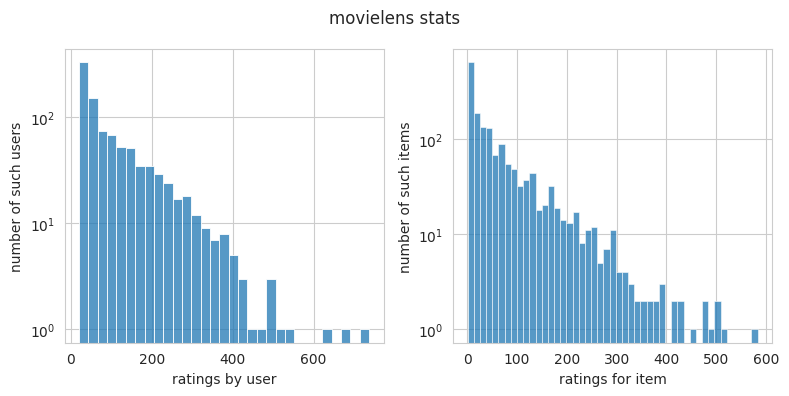

In [ ]:
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt

rating_counts = [len(ur) for ur in trainset.ur.values()]
user_counts = [len(ir) for ir in trainset.ir.values()]

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
sns.histplot(x=rating_counts, ax=ax[0])
sns.histplot(x=user_counts, ax=ax[1])
ax[0].set_xlabel('ratings by user')
ax[1].set_xlabel('ratings for item')
ax[0].set_ylabel('number of such users')
ax[1].set_ylabel('number of such items')
ax[0].set_yscale('log')
ax[1].set_yscale('log')
fig.suptitle('movielens stats')
plt.tight_layout()
plt.show()

## KNNBasic

### Data Stuff

In [ ]:
! wget https://files.grouplens.org/datasets/movielens/ml-100k.zip

--2023-10-01 12:59:59--  https://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4,7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4,70M  1,32MB/s    in 3,7s    

2023-10-01 13:00:03 (1,27 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]



In [ ]:
! unzip ml-100k.zip

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


In [1]:
import pandas as pd
import numpy as np
import os


def load(fname, path='/home/ilya/repos/recsys/hw1/ml-100k'):
    path = os.path.join(path, fname)
    return pd.read_csv(path, sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp']).drop(columns=['timestamp'])

df = load('ua.base')
df.describe()

,user_id,item_id,rating
count,90570.000000,90570.000000,90570.000000
mean,461.494038,428.104891,3.523827
std,266.004364,333.088029,1.126073
min,1.000000,1.000000,1.000000
25%,256.000000,174.000000,3.000000
50%,442.000000,324.000000,4.000000
75%,682.000000,636.000000,4.000000
max,943.000000,1682.000000,5.000000


In [2]:
def load_train():
    return load('ua.base')
def load_test():
    return load('ua.test')

df_train = load_train()
df_test = load_train()

Разделение на сплиты корректно:

In [3]:
print(len(set(df_test.item_id.unique()) - set(df_train.item_id.unique())))
print(len(set(df_test.user_id.unique()) - set(df_train.user_id.unique())))

0
0


### Implementing

In [4]:
metric = 'msd'
min_support = 1
k = 2

In [5]:
from hw1.colfil.knn import _preprocess, _n_common_items, _similarities, _k_neighbors, _predictions, knn_user_based

pred = knn_user_based(df_train, df_test, k, metric, min_support, verbose=True, with_means=True)

...preprocessing
...counting common items
...computing similarities
...finding neighbors
...predicting


In [6]:
pred.loc[pred.impossible]

,rating,impossible,_user_id,_item_id
1048,-inf,True,6,575
1124,-inf,True,6,651
1364,-inf,True,9,687
2100,-inf,True,12,805
2116,-inf,True,12,821
...,...,...,...,...
82471,-inf,True,862,1675
82472,-inf,True,862,1676
84897,-inf,True,882,1677
86747,-inf,True,895,1678


### Experimenting